### Fala dev! 

Nessa parte do tutoral, vamos entender o conceito de vector databases e vector stores

### O que são vector stores?

Agora que compreendemos o conceito de embeddings e suas aplicações, vamos explorar uma abordagem otimizada para utilizá-los em cenários práticos.

Os embeddings geralmente possuem dimensões elevadas, o que torna a busca por similaridades entre eles uma tarefa desafiadora, especialmente para bancos de dados tradicionais, que não foram projetados para lidar com esse tipo de operação de maneira eficiente. Esse processo de busca envolve cálculos complexos, como a determinação de métricas de distância, comparação dessas métricas e a recuperação de informações associadas, como o texto relacionado a cada vetor.

Para resolver essas limitações, surgem os vector stores (bancos de dados vetoriais), estruturas de armazenamento otimizadas especificamente para lidar com operações envolvendo embeddings. Esses bancos de dados foram projetados para realizar cálculos, armazenar dados e recuperar informações de forma eficiente, possibilitando buscas de alta performance e escaláveis em ambientes de produção. Com essas otimizações, vector stores tornam-se indispensáveis para aplicações que demandam processamento de grandes volumes de dados vetoriais e consultas rápidas e precisas.

### Existe diferença entre vector database e vector store?

Existe. Apesar dos nomes serem parecidos, a diferença entre eles é que o vector database é um banco de dados que armazena os vetores, enquanto um vector store é um serviço que armazena os vetores.


| Aspecto | Vector Store | Vector Database |
|---------|--------------|-----------------|
| Objetivo | Armazenar vetores | Armazenar e realizar consultas eficientes sobre vetores |
| Funcionalidades | Armazenamento e recuperação básica | Indexação vetorial, consultas de similaridade, k-NN |
| Integração | Geralmente sobre outros sistemas de armazenamento | Solução independente especializada em vetores |
| Escalabilidade | Limitada a funcionalidades básicas | Otimizado para grandes volumes de vetores e alta performance |
| Complexidade | Simples | Mais complexo, com suporte a operações avançadas |
| Exemplos de Uso | Cenários simples de armazenamento | Motores de busca semânticos, recomendações, NLP |
| Exemplos de Ferramentas | Simples módulos de armazenamento (p.ex., camadas de memória) | Pinecone, Milvus, Weaviate |

Alguns exemplos de serviços existentes:

### Vector Store:
FAISS (Facebook AI Similarity Search): É uma biblioteca desenvolvida pelo Facebook para buscar em grandes conjuntos de vetores. Embora seja poderosa, FAISS é mais uma biblioteca de indexação e busca, não um banco de dados completo.

### Vector Database:
Pinecone: Uma solução de banco de dados vetorial gerenciado que oferece armazenamento, indexação e consulta de vetores. É projetado para busca e recuperação de alta performance em vetores.


### Aprofundando um pouco mais:

Uma das maneiras mais comuns de armazenar e pesquisar dados não estruturados é incorporá-los e armazenar os vetores de incorporação resultantes e, em seguida, no momento da consulta, incorporar a consulta não estruturada e recuperar os vetores de incorporação que são 'mais semelhantes' à consulta incorporada. Um armazenamento de vetores se encarrega de armazenar dados incorporados e realizar pesquisas de vetores para você.

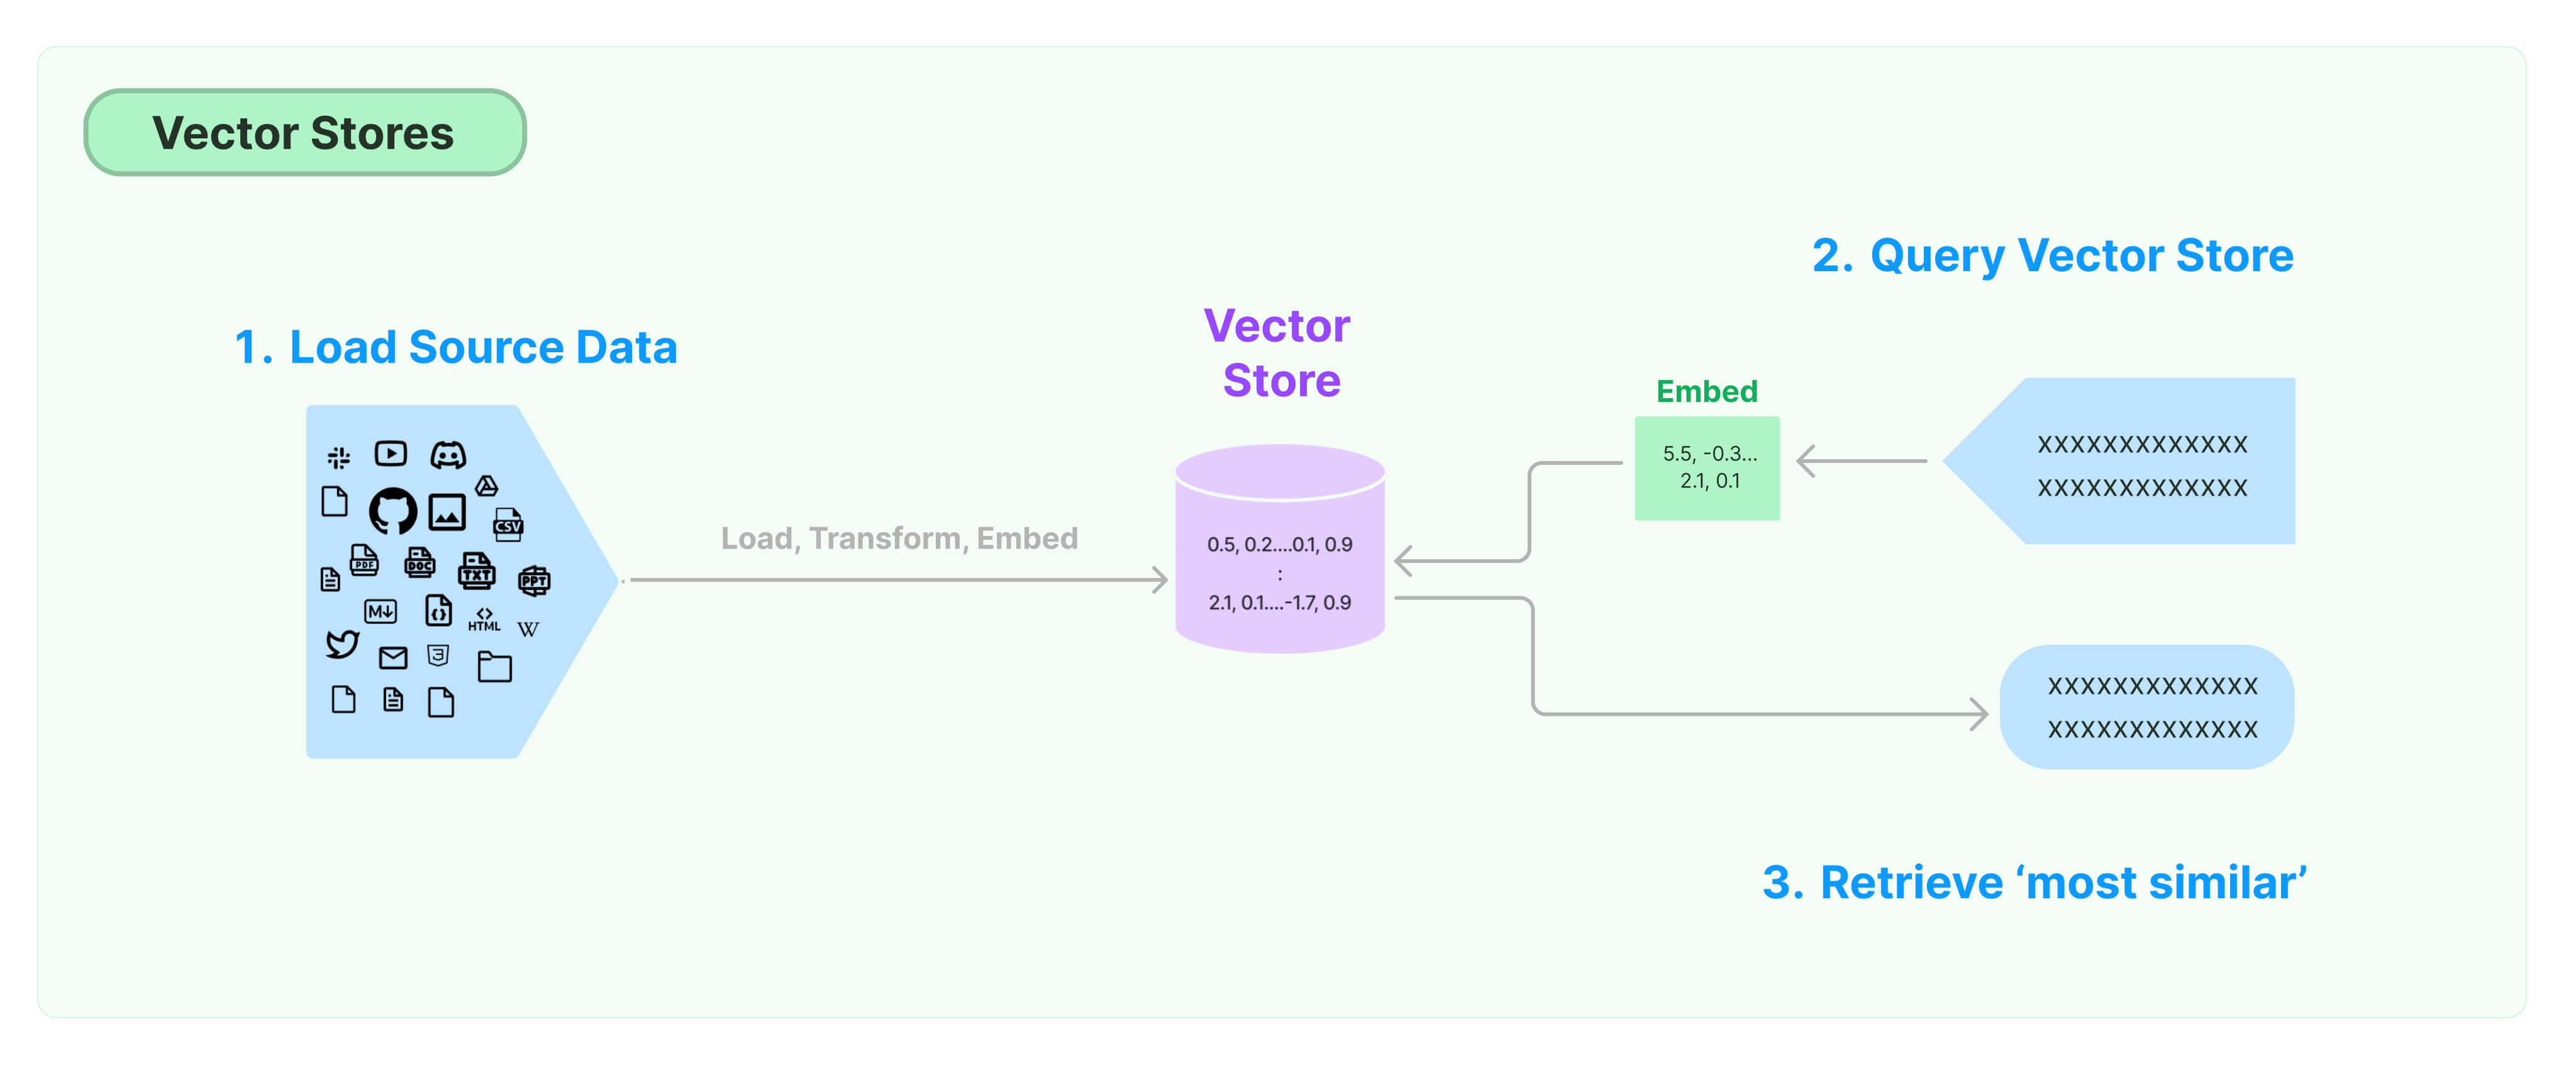

Este passo a passo apresenta funcionalidades básicas relacionadas aos armazenamentos de vetores. Uma parte fundamental do trabalho com armazenamentos de vetores é criar o vetor a ser colocado neles, que geralmente é criado por meio de embeddings. Portanto, é recomendável que você se familiarize com as interfaces do modelo de incorporação de texto antes de mergulhar nisso.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS

from dotenv import load_dotenv
import os

from tqdm import tqdm

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [4]:
#Aqui, definimos o modelo de embeddings que será utilizado para vetorizar os textos
embedding_size = 1536
embedding_model = "text-embedding-3-small"
embeddings = OpenAIEmbeddings(model=embedding_model, dimensions=embedding_size)

## Carregando os dados:

Instanciando o PyPDFLoader, temos um objeto de loader do lanchain. No momento em que essa classe é instanciada, colocamos o caminho do arquivo PDF que queremos ler, e o objeto resultante tem um método chamado .load(). 
Esse método permite a leitura do arquivo PDF, e o resultado é o texto presente no PDF dentro de um objeto "Document", que faz parte da biblioteca do langchain e é a base dessa dinâmica de leitura de documentos da biblioteca.

In [6]:
file_path_ed_financeira = "../data/educacao_financeira.pdf"
file_path_historia = "../data/historia.pdf"
loader_historia = PyPDFLoader(file_path_historia)
loader_ed_financeira = PyPDFLoader(file_path_ed_financeira)
pages_historia = loader_historia.load()
pages_ed_financeira = loader_ed_financeira.load()

all_docs = pages_historia + pages_ed_financeira

In [8]:
len(all_docs)

420

### Adicionando ao Vector Store

Aqui, utilizamos o vector store FAISS (Facebook AI Similarity Search) para carregar os embeddings 
Para criar o vectorstore, utilizamos a classe FAISS, importada do langchain, que contém facilitadores para o uso desse Vectorstore.
Ao usarmos .from_documents, criamos um vector store a partir dos Documents do langchain

In [9]:
vector_db = FAISS.from_documents(all_docs, embeddings)

In [10]:
# os vectorstores também podem ser salvos locamente para serem usados posteriormente. Ou seja, você pode embeddar seus dados uma vez, salvar num vectorstore, e usá-lo outras vezes sem precisar re-embeddar os dados.
vector_db.save_local("../vectorstore/historia_ed_financeira")

## Carregando um vectorstore local

In [11]:
vdb = FAISS.load_local("../vectorstore/historia_ed_financeira", 
                       embeddings, 
                       allow_dangerous_deserialization=True)

In [12]:
# Aqui, utilizamos o vectorstore como um retriever
# Um retriever, é um objeto que permite fazer buscas por similaridade de vetores
retriever = vdb.as_retriever(search_kwargs={"k": 4})

In [13]:
#o método .invoke é utilizado para fazer as buscas de similaridade, de fato. 
# o método toma como argumento uma string, e retorna os textos mais similares a essa string, dentro do vectorstor
retriever.invoke("Quanto pesa seu sonho?")

[Document(id='2a0b4941-1bd8-4d17-bbe0-bb5e89b6aa5e', metadata={'source': '../data/educacao_financeira.pdf', 'page': 48}, page_content='3636\nO que pesa mais, um quilo de algodão ou um quilo de chum-\nbo? Muita gente responde chumbo ao ouvir esta pergunta, \nmas, na verdade, os dois pesam a mesma coisa: um quilo. \nNa hora de pensar nas nossas despesas, também podemos \nficar confusos e acabar dando pesos equivocados a cada coi-\nsa. Às vezes, achamos que estamos gastando muito em uma \ncoisa, quando o que está pesando no nosso bolso na verdade \né outra. \nquaNTO pesa O seu sONhO? \nVocê e sua família devem ter alguns sonhos e projetos que pa-\nrecem muito distantes porque nunca sobra dinheiro suficien-\nte no final do mês para realizá-los. O que fazer nesse caso?\nAntes de tudo, seria bom vocês elegerem um dos projetos que \nquerem realizar para ter um foco bem concreto. Isso ajuda a \nmanter o esforço da família para conseguir o dinheiro neces-\nsário. Escolheu um foco?\nAgora você v